## Example 1 - Python Conventions

### Original

Python convention is to use the underscore (`_`) only when the variable doesn't matter and isn't being used. Since the variable is being used, it should have a descriptive name.

In [0]:
names = df.drop(columns=['Rating', 'ID']).columns.tolist()
names.sort()

for _ in names:
  dfEx = pd.DataFrame(columns=['Rating','Ex'])
  dfEx['Rating'] = df['Rating']
  dfEx['Ex'] = df[_]
  dfEx = dfEx.loc[dfEx['Ex'], :]
  print()
  print(_)
  print(dfEx['Rating'].value_counts())

### Refactored

On top of the naming convention, the code can be reduced through the use of groupby.

In [0]:
for col in df.columns.drop(['Rating', 'ID']):
  print('\n' + col)
  print(df.groupby(col)['Rating'].value_counts()[1])

## Example 2 - Simplified with Library Methods

### Original

Student had multiple chunks of code like the one below, using them to manually tune each of the hyperparameters.

In [0]:
score2 = score1
for _ in range(1,20):
  p_loop = make_pipeline(DecisionTreeClassifier(random_state=138, max_depth=_))
  p_loop.fit(x_train,y_train)
  p_score = p_loop.score(x_val, y_val)
  print(_,'\t',p_score)
  if (p_score > score2):
    score2 = p_score
    print('^^^')

### Refactored

Instead of copying and pasting the same code five times to find the best hyperparameters, use `RandomizedSearchCV` or `GridSearchCV`. Both are designed to find the best hyperparameters without you having to manually do it.

In [0]:
decision_tree = DecisionTreeClassifier(n_jobs=-1, random_state=138)

param_distributions = {'max_depth': range(1, 20),
                       'min_samples_split': range(2, 30),
                       'min_samples_leaf': range(2, 30),
                       'max_leaf_nodes': range(2, 300),
                       'min_impurity_decrease': range(0, 300)}

search = RandomizedSearchCV(decision_tree, 
                            param_distributions=param_distributions,
                            scoring='accuracy', n_iter=500, n_jobs=-1, cv=5,
                            verbose=10, return_train_score=True, 
                            random_state=42)
search.fit(X_train, y_train)

print('Training Accuracy Score:', search.best_score_)

# Example 3 - Functions for DRY and Readable Code

## Original

The `data_wrangle` function is long when it could be cleaned up with small helper functions. In addition, there are quite a few comments that can be removed with descriptive variable and function names, leading to self-commenting code.

In [0]:
def word_count(str):
  ''' function used for finding the unique number of words for
  each review in the data wrangling function''' 

  counts = dict()
  words = str.split()

  for word in words:
    if word in counts:
      counts[word] += 1
    else:
      counts[word] = 1
    
  return len(counts.keys())



def data_wrangle(df):
  ''' Wrangles the data in specified ways using a copy of the dataframe to 
  prevent the setting copy warning'''

  # set the copy
  df = df.copy()

  # Renaming columns and dropping redundancy 
  df = df.rename(columns={
    'reviewid':'review_id', 'artist_x':'artist'}).drop(columns=['artist_y'])

  # # Datetime format
  # df['pub_date'] = pd.to_datetime(df['pub_date'], infer_datetime_format=True)

  # dropping the pub_date column instead, since it is extracted into 
  # weekday, month, and year... this is to help with regression and classification
  df = df.drop(columns=['pub_date'])

  # Dropping 'url' ... doesn't seem to be worth much for a model
  df = df.drop(columns=['url'])

  # dropping two null artist rows
  df = df[df['artist'].isna() != True]

  # dropping 'various artists' to better understand how data is tied to 'artist'
  df = df[df['artist'] != 'various artists']

  # filling nulls with 'other', 'untitled', and 'unspecified' respectively
  df['label'] = df['label'].fillna('other')
  df['author_type'] = df['author_type'].fillna('other')
  df['title'] = df['title'].fillna('untitled')
  df['genre'] = df['genre'].fillna('unspecified')
  df['content'] = df['content'].fillna('no content')

  # Feature Engineering: Content Length and Content Unique values
  df['content_length'] = df['content'].str.len().astype(float)
  df['content_unique'] = [word_count(review) for review in df['content']]

  # Set 'best_new_music' to yes / no with 'best_new_music_class
  df['best_new_music_class'] = df['best_new_music'].map({1:'yes', 0:'no'})

  # Where year is null, setting it to the adjacent column value
  df['year'] = np.where(df['year'].isna() == True, df['pub_year'], df['year'])

  # Feature engineering: mean scores per label and genre (note: could leak)
  df['label_mean_score'] = df.groupby('label')['score'].transform('mean')
  df['genre_mean_score'] = df.groupby('genre')['score'].transform('mean')
  
  return df

## Refactored

- Improved `word_count` through the use of existing methods in the `string` library.
- Able to drop the doc strings  and most comments by having descriptive function names
- Removed commented out code that had been left in
- `wrangle` function becomes much more readable and digestible with various operations compartmentalized in their own functions.
- Overall length of the code is shorter even with the line overhead of `def` and `return` in each function, and the additional spacing between functions.
- PEP8 conventions enforced

In [0]:
def unique_word_count(review):
  review = review.translate(str.maketrans('', '', string.punctuation)).lower()

  return len(set(review.split()))


def fill_nulls(df):
  df = df.copy()
  null_values = {'label': 'other', 'author_type': 'other', 'title': 'untitled',
                 'genre': 'unspecified', 'content': 'no content'}
  
  for column in null_values:
    df[column] = df[column].fillna(null_values[column])
  
  # Where year is null, setting it to pub_year
  df['year'] = np.where(df['year'].isna(), df['pub_year'], df['year'])
  
  return df


def filter_for_solo_artists(df):
  df = df.copy()
  
  df = df[df['artist'].notna()]
  df = df[df['artist'] != 'various artists']
  
  return df


def engineer_features(df):
  df = df.copy()
  
  df['content_length'] = df['content'].str.len()
  df['content_unique'] = df['content'].apply(unique_word_count)
  
  df['label_mean_score'] = df.groupby('label')['score'].transform('mean')
  df['genre_mean_score'] = df.groupby('genre')['score'].transform('mean')
  
  df['best_new_music_class'] = df['best_new_music'].map({1:'yes', 0:'no'})
  
  return df


def wrangle(df):
  df = df.copy()
  
  df = df.rename(columns={'reviewid': 'review_id', 'artist_x': 'artist'})
  
  df = fill_nulls(df)
  df = filter_for_solo_artists(df)
  df = engineer_features(df)
  
  # Dropping low value, duplicate, and leaky features
  drop_features = ['artist_y', 'pub_date', 'url', 'best_new_music']
  df = df.drop(columns=drop_features)
  
  return df

# Example 4 - Logical Groupings and Whitespace

## Original

Student does a decent job of chunking the imports and even has comments to make the chunks even more clear, however there is ordering that can be improved.

In [0]:
#number manipulation and plotting imports
import pandas as pd
import numpy as np
!pip install matplotlib==3.1.0
import matplotlib.pyplot as plt
import seaborn as sns

#training imports
from sklearn.model_selection import train_test_split
!pip install -U pandas-profiling
import pandas_profiling
!pip install category_encoders
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

#analysis imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.stats import randint, uniform
!pip install eli5
import eli5
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot
from eli5.sklearn import PermutationImportance
!pip install shap
import shap

## Refactored

- Imports are grouped in chunks like before, but also grouped by library withing the chunks
- Moved all installs into a separate cell to prevent rerunning installs
- Notebook settings like `%matplotlib inline` are moved to the bottom

In [0]:
!pip install shap, eli5, category_encoders, matplotlib==3.1.0
!pip install -U pandas-profiling

In [0]:
# Number manipulation and plotting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Training imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas_profiling
import category_encoders as ce

# Analysis imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
from scipy.stats import randint
from scipy.stats import uniform
from pdpbox.pdp import pdp_isolate
from pdpbox.pdp import pdp_plot
from yellowbrick.cluster import KElbowVisualizer
import eli5
import shap

%matplotlib inline

## Alternative Refactor

- Grouped imports to a single line when possible

In [0]:
!pip install shap, eli5, category_encoders, matplotlib==3.1.0
!pip install -U pandas-profiling

In [0]:
# Number manipulation and plotting imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Training imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
import pandas_profiling
import category_encoders as ce

# Analysis imports
from sklearn.metrics import accuracy_score, classification_report,
                            confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import KMeans
from scipy.stats import randint, uniform
from pdpbox.pdp import pdp_isolate, pdp_plot
from yellowbrick.cluster import KElbowVisualizer
import eli5
import shap

%matplotlib inline

# Example 5 - Copy Paste Code

## Original

- Multiple lines repeating the same piece of code with minor variations
- Dead code commented out but left in
- Functions would improve readability and clarity

In [0]:
# declare list of columns you want to edit
wrangle_col = ['SubjectAge', 'OfficerGender',
                'OfficerRace', 'SubjectGender',
                'SubjectRace']

# create dictionary of bad characters
bad_chars = {'/':'', ':':';', ' ':'', 'H':'L'}

def wrangle(df):
  
  df = df.copy()

  # strip out leading and trailing spaces
  for col in df[wrangle_col]:
    df[col] = df[col].str.strip()

  # replace un-uniform characters
  for col in df[wrangle_col]:
    for char in bad_chars:
      df[col] = df[col].str.replace('/', '')
      df[col] = df[col].str.replace(':', ';')
      df[col] = df[col].str.replace(' ', '')
      df[col] = df[col].str.replace('H', 'L')
      df[col] = df[col].str.replace('OtLer', 'Other')
      df[col] = df[col].str.replace('WLITE', 'WHITE')
  
  # make a list feature of these
  # df['OfficerGenderList'] = df['OfficerGender'].str.split(pat=';')

  # df['OfficerRaceList'] = df['OfficerRace'].str.split(pat=';')

  # pull out month day and year for df
  df['year_recorded'] = df['Date'].dt.year
  df['month_recorded'] = df['Date'].dt.month
  df['day_recorded'] = df['Date'].dt.day
  df = df.drop(columns='Date')
  df = df.drop(columns='NatureOfStop')
  df = df.drop(columns='Notes')
  df = df.drop(columns='NumberOfSubjects')

  return df

## Refactored

- Use lists, loops, and functions to make code DRY
- Use helper functions to make the wrangle function more readable and make it clear what is happening.

In [0]:
def clean_string_columns(df, columns):
  df = df.copy()
  replacement_dict = {'/':'', ':':';', ' ':'', 
                      'H':'L', 'OtLer':'Other', 'WLITE':'WHITE'}
  
  for col in columns:
    df[col] = df[col].str.strip()
    for old, new in replacement_dict.items():
      df[col] = df[col].str.replace(old, new)
  
  return df


def split_datetime(df):
  df = df.copy()
  
  df['year_recorded'] = df['Date'].dt.year
  df['month_recorded'] = df['Date'].dt.month
  df['day_recorded'] = df['Date'].dt.day
  
  return df


def wrangle(df):
  df = df.copy()
  columns_to_clean = ['SubjectAge', 'OfficerGender', 'OfficerRace',
                      'SubjectGender', 'SubjectRace']
  
  df = clean_string_columns(df, columns_to_clean)
  df = split_datetime(df)
  df = df.drop(columns = ['Date', 'NatureOfStop', 'Notes', 'NumberOfSubjects'])
  
  return df

# Example 6 - Understanding Methods Fully

## Original

- All columns with nulls are listed explicitly
- `null_cols` isn't used anywhere else in the code, could have been moved into the function to limit scope
- `inplace=True` should be discouraged. Explicit assignment is more universal and is more readable

In [0]:
null_cols = ['Closed Date', 'Due Date', 'Descriptor', 'Location Type', 'Incident Zip',
             'City', 'Latitude', 'Longitude']

def drop_nulls(df_nyc):
    for cols in null_cols:
        df_nyc = df_nyc.dropna(subset=[null_cols], inplace=True)
        
    return df_nyc

df_nyc = drop_nulls(df_nyc)

## Refactored

- Knowing how `dropna` works means we don't have to worry about negative interactions with columns that don't have nulls. This allows for a reduction from 10 lines to 1.

In [0]:
df_nyc = df_nyc.dropna()

## Example 7 - Visual Cleanliness

## Original Notebook

Presentation matters, graphs should be quick and easy to read but this one has a lot of rows and whitespace. It could also use a title.

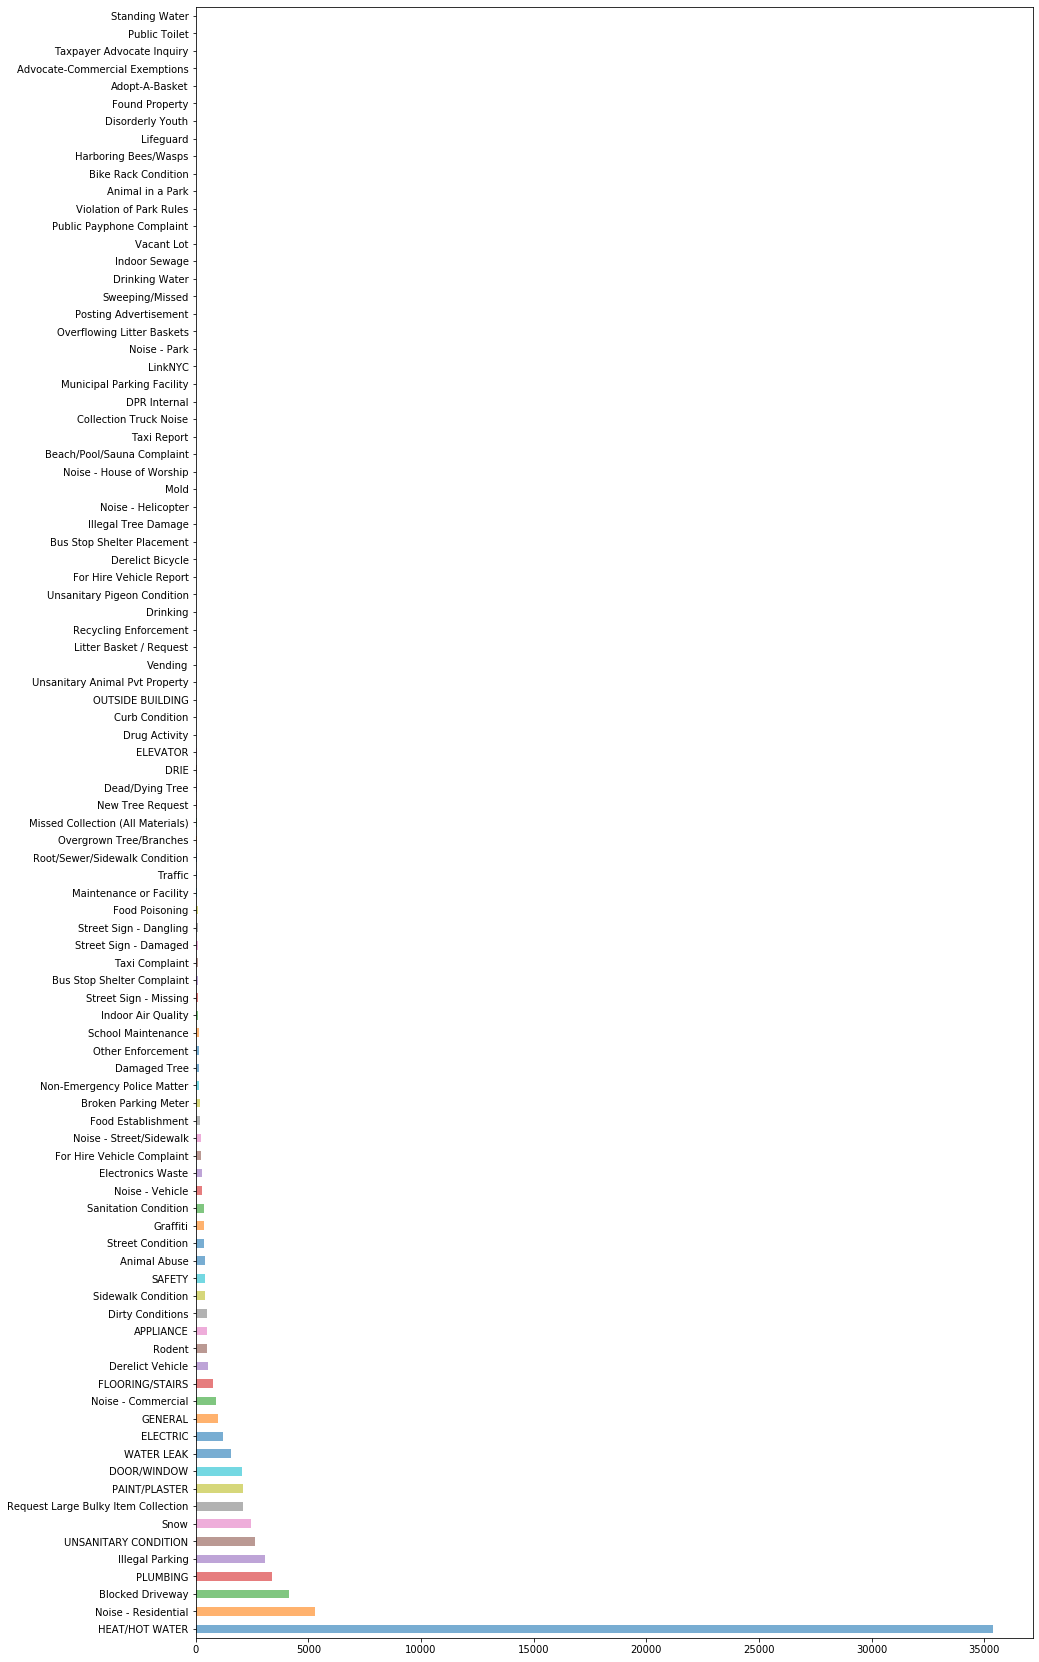

In [0]:
train['complaint_type'].value_counts().plot(kind='barh', alpha=0.6, figsize=(15,30))

plt.show()

### Refactored

Filter for top 10 to remove all of the whitespace and results that are uninteresting. Added title to further improve readability and interpretability of the graph.

In [0]:
top_complaints = train['complaint_type'].value_counts(sort_ascending=False)[:10]
top_complaints.plot(kind='barh', alpha=0.6, figsize=(15,30),
                    title='Top 10 "311" Complaints for NYC')

plt.show()

# Example 8 - Descriptive Variable Names

## Original

Biggest issue is the use of `word` as a variable name when a more descriptive name could be used instead.

In [0]:
for word in ["achilles", "knee", "concussion", "ankle", "back", "hamstring", 
             "quadriceps", "hip", "wrist",  "neck", "calf", "foot", "hand", 
             "thumb", "elbow", "shoulder", "groin", "finger"]:
          just_injuries[word] = just_injuries["notes"].str.contains(word)
just_injuries.head()

## Refactored

In [0]:
body_parts = ["achilles", "knee", "concussion", "ankle", "back", "hamstring",
              "quadriceps", "hip", "wrist",  "neck", "calf", "foot", "hand", 
              "thumb", "elbow", "shoulder", "groin", "finger"]

for body_part in body_parts:
    just_injuries[body_part] = just_injuries["notes"].str.contains(body_part)

just_injuries.head()

# Example 9

## Original
- Chunking could be improved
- `i` is not a great variable name when we can use a descriptive name in this case
- Biggest issue is a formula that is unexplained and not common. This causes a reader to slow down to figure out what the purpose is.

In [0]:
# UPDATE 'date' COLUMN TO WEEK (1-17) ON 'elo' DATASET
elo['date'] = pd.to_datetime(elo['date'], format='%Y-%m-%d')

def week_calculator(date_list):
  week_list = []
  week = 0
  start = date_list[0]

  for i in range(len(date_list)):
    if date_list[i] < start + datetime.timedelta(days=7):
      week_list.append(week)
    else:
      week += 1
      week_list.append(week)
      start = date_list[i]
  
  return [week_list[i] % 17 + 1 for i in range(len(week_list))]

elo['week'] = week_calculator(elo['date'].tolist())
elo = elo.drop(['date'], axis=1)

## Refactored

- Break the function and other lines of code into two cells
- Utilize the flexible functionality of Python for loops to replace `i` with `current_date`
- Added comment to explain the mystery numbers and equation

In [0]:
def week_calculator(date_list):
  week_list = []
  week = 0
  week_start = date_list[0]

  for current_date in date_list:
    if current_date < week_start + datetime.timedelta(days=7):
      week_list.append(week)
    else:
      week += 1
      week_list.append(week)
      week_start = current_date
  
  # Adjust week to account for season
  return [week % 17 + 1 for week in week_list]

In [0]:
# UPDATE 'date' COLUMN TO WEEK (1-17) ON 'elo' DATASET
elo['date'] = pd.to_datetime(elo['date'], format='%Y-%m-%d')
elo['week'] = week_calculator(elo['date'].tolist())
elo = elo.drop(['date'], axis=1)